In [27]:
%matplotlib inline

import os,sys,inspect
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import model.model_util as mu

In [2]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')

In [25]:
# load data

with open("../data/top_5_contacts_cal.df", "rb") as raw_file:
    top_5_raw_df = pickle.load(raw_file)
    
with open("../data/coe_contact_all.df", "rb") as raw_file:
    all_raw_df = pickle.load(raw_file)

with open('../data/demographics.df', 'rb') as demo_file:
    demo_df = pickle.load(demo_file)
demo_cols = ['pid', 'age', 'gender', 'education', 'employment', 'live_together', 'race', 'ethnicity', 'marital_status']

# Measuring Relationships and their Meaning from Phone Data

## Motivation

### Field domain
- social relationships and communication tie strength
- passive mobile device sensing
- ML for life-facet prediction (Zimmerman group)

## The gap we fill

- use of additional phone sensor data to contextualize communication
- user of AutoML to remove engineering bias in model choice/performance tuning
- finer grained social relationship role prediction

## Methods: raw features

### Communication logs

- SMS, call logs: incoming, outgoing, missed, timestamp
- call duration (no text length)
- 406,317 communication events and 9,645 EMA contact information collected

![](../tex/figures/call_trend.png)


### Survey data: contact type

|Question/measure label | Response range|
|-|-|
|contact_type |	{Significant Other, Friend, Family Member You Live With, Family Member You Don't Live With, Colleague/Work-Related, Task (e.g. Make an Appointment, Reservation, etc.), Other}|
|want_question |	{1 (Not At All), 2, 3, 4 (Some), 5, 6, 7 (Extremely Close)}|
|talk_question |	{1 (Strongly Disagree), 2 (Disagree), 3 (Somewhat Disagree), 4 (Neither Agree Or Disagree), 5 (Somewhat Agree), 6 (Agree), 7 (Strongly Agree)}|
|loan_question |	{1 (Strongly Disagree), 2 (Disagree), 3 (Somewhat Disagree), 4 (Neither Agree Or Disagree), 5 (Somewhat Agree), 6 (Agree), 7 (Strongly Agree)} |
|closeness |	{1 (Not At All), 2, 3, 4 (Some), 5, 6, 7 (Extremely Close)} |


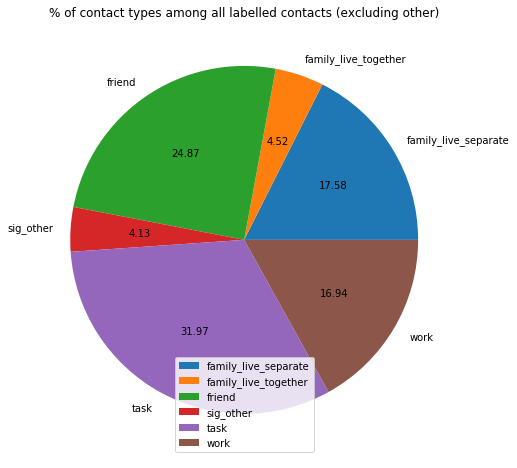

In [24]:
all_types = all_raw_df.loc[all_raw_df['contact_type'] != 'other']
all_types = all_types.drop_duplicates('combined_hash').groupby('contact_type').count()
all_types.plot.pie('comm_type', autopct='%.2f', figsize=(8,8))
plt.title('% of contact types among all labelled contacts (excluding other)')
plt.legend(loc='lower center')
plt.ylabel("")
plt.show()

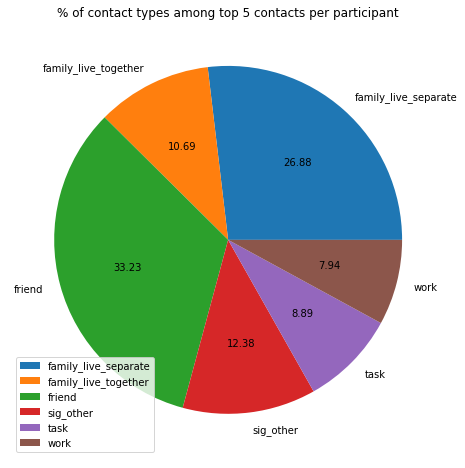

In [17]:
top_types = raw_df.drop_duplicates('combined_hash').groupby('contact_type').count()
top_types.plot.pie('comm_type', autopct='%.2f', figsize=(8,8))
plt.title('% of contact types among top 5 contacts per participant')
plt.legend(loc='lower left')
plt.ylabel("")
plt.show()

### Demographics

| label | item |
|-------|------|
|demo08	| Birthdate|
|demo09 |Gender |
|demo09_oth |Other|
|demo10_1  |How do you define your race? Black or African American (Having origins in any of the black racial groups of Africa)|
|demo10_2 |How do you define your race? American Indian (North; South or Central) or Alaska Native (Having origins in any of the original peoples of North; Central or South America)|
|demo10_3 |How do you define your race? Asian (Having origins in any of the original peoples of the Far East; Southeast Asia; or the Indian Subcontinent. For example: Cambodia; China; India; Japan; Korea; Malaysia; Pakistan; the Philippine Islands; Thailand; and Vietnam)|
|demo10_4 | How do you define your race? Native Hawaiian or Other Pacific Islander (Having origins in any of the original peoples of Hawaii; Guam; Samoa or other Pacific Islands)|
|demo10_5 |How do you define your race? White (Having origins in any of the original peoples of Europe; the Middle East; or North Africa) |
|demo10_6 |How do you define your race? Prefer not to answer |
|demo11	|What is your ethnic identity? |
|demo12 |What is the highest level of education you have received?
|demo13	|Please select your most current marital status|
|demo14	|Do you live with others?|

- age
- gender
- race
- education
- marital status

- living with others
- employment status

In [26]:
# TODO drop in demographic features

### Semantic location

- TODO Sohrab's chart

## Methods: feature extraction

### Intensity and regularity
- \# days {call, sms} / days logged
- {avg, std, min, max, med} {out, in} {call, sms} per day
- {avg, max} call duration

### Temporal tendency
- \# {call, sms} at {time of day, day of week} / total

### Channel selection
- out comm / total comm
- \# calls / total comm
    
### Avoidance
- missed calls / {out, in} calls
- in SMS / out SMS

## Methods: AutoML

- TODO paste in points from Overleaf

## Results: 6-class relationship prediction

- majority classifier
- baseline
- be sure to report CV and test error

In [ ]:
# load models



## Results: contact type analysis

## Results: 4-class relationship prediction

# Outline

- intro/motivation
- methods
    - raw data features
    - feature extraction
    - autoML
- results
    - "original" task: confusion matrix, baseline, etc
    - communication label analysis: why the confusions are made
    - "collapsed" task: confusion matrix, baseline, etc
    - analysis of EMC results
- discussion
    - what we've learned about social support
    - caveats to autoML:
        - no block feature selection
        - no variable importance implemented (yet)
    - size of data:
        - can run additional analyses with round 2 of LifeSense study